In [21]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


In [22]:
csv_path = 'Data/weatherHistory.csv'
df = pd.read_csv(csv_path)
df.sort_values(by='Formatted Date', inplace = True)

In [23]:
features_considered = ['Temperature (C)', 'Humidity']

In [24]:
features = df[features_considered]
features.index = df['Formatted Date']
features.head()

,Temperature (C),Humidity
Formatted Date,,
2006-01-01 00:00:00.000 +0100,0.577778,0.89
2006-01-01 01:00:00.000 +0100,1.161111,0.85
2006-01-01 02:00:00.000 +0100,1.666667,0.82
2006-01-01 03:00:00.000 +0100,1.711111,0.82
2006-01-01 04:00:00.000 +0100,1.183333,0.86


array([<Axes: xlabel='Formatted Date'>, <Axes: xlabel='Formatted Date'>],
      dtype=object)

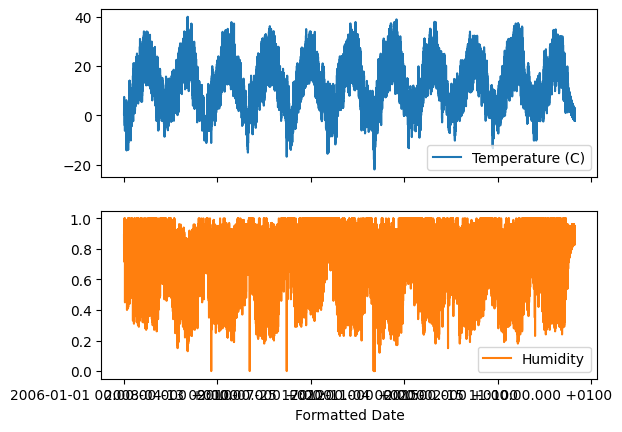

In [25]:
features.plot(subplots=True)

In [26]:
TRAIN_SPLIT = 70000

In [27]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [28]:
dataset = (dataset-data_mean)/data_std

In [29]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [30]:
past_history = 720
# future_target = 72 #12 hrs, observation every 10 minutes
# 6, 8, 12, 24 hrs -> 36, 48, 72, 144
targets = [36, 48, 72, 144]
STEP = 6
models = []
histories = []
future_target = 144

In [31]:
target_selection = dataset[:, 0]  # dataset[:, 0] - temp, dataset[:, 1] - humidity
x_train_multi, y_train_multi = multivariate_data(
    dataset, target_selection, 0, TRAIN_SPLIT, past_history, future_target, STEP
)
x_val_multi, y_val_multi = multivariate_data(
    dataset, target_selection, TRAIN_SPLIT, None, past_history, future_target, STEP
)
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = (
    train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
)

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(
    tf.keras.layers.LSTM(
        32, return_sequences=True, input_shape=x_train_multi.shape[-2:]
    )
)
multi_step_model.add(tf.keras.layers.LSTM(16, activation="relu"))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss="mae"
)

EPOCHS = 20
EVALUATION_INTERVAL = 200
multi_step_history = multi_step_model.fit(
    train_data_multi,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_data_multi,
    validation_steps=50,
)

hrs = future_target / 6
path_name = "my_saved_lstm_for_temp" + str(hrs) + "hrs.keras"
multi_step_model.save(path_name)
models.append(multi_step_model)
histories.append(multi_step_history)

Epoch 1/20


/home/michal/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 126ms/step - loss: 0.7470 - val_loss: 0.7152
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 124ms/step - loss: 0.7099 - val_loss: 0.6852
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - loss: 0.6800 - val_loss: 0.6101
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - loss: 0.5515 - val_loss: 0.4916
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - loss: 0.4894 - val_loss: 0.4822
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - loss: 0.5014 - val_loss: 0.4819
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - loss: 0.4825 - val_loss: 0.4708
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - loss: 0.4690 - val_loss: 0.4978
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - loss: 0.4782 - val_loss: 0.4573
Epoch 10/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - loss: 0.4930 - val_loss: 0.4912
Epoch 11/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 118ms/step - loss: 0.4695 - val_loss: 0.4438
Epoch 12/20
200/200 ━━━━━━━━━━

In [32]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 2)

 Target temperature to predict : (72,)


In [33]:
def create_time_steps(length):
  return list(range(-length, 0))

In [34]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

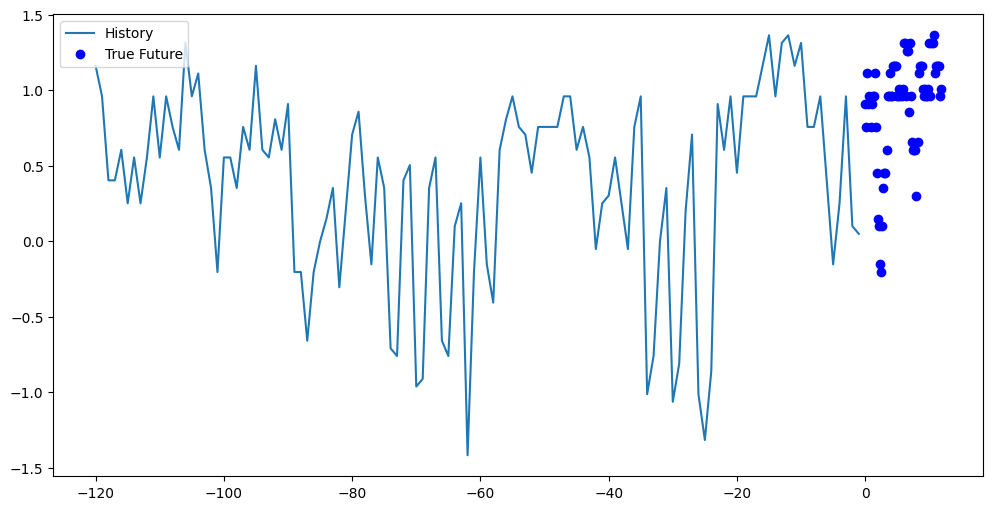

2024-06-18 15:30:53.865701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [35]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [36]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
(256, 72)


2024-06-18 15:30:54.617558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [37]:
from tensorflow.keras.models import load_model
model_path = "my_saved_lstm_for_temp24.0hrs.keras"
# Ładowanie modelu
model = load_model(model_path)


In [38]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

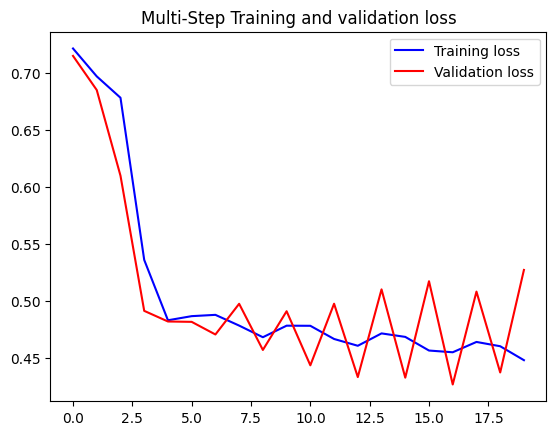

In [39]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


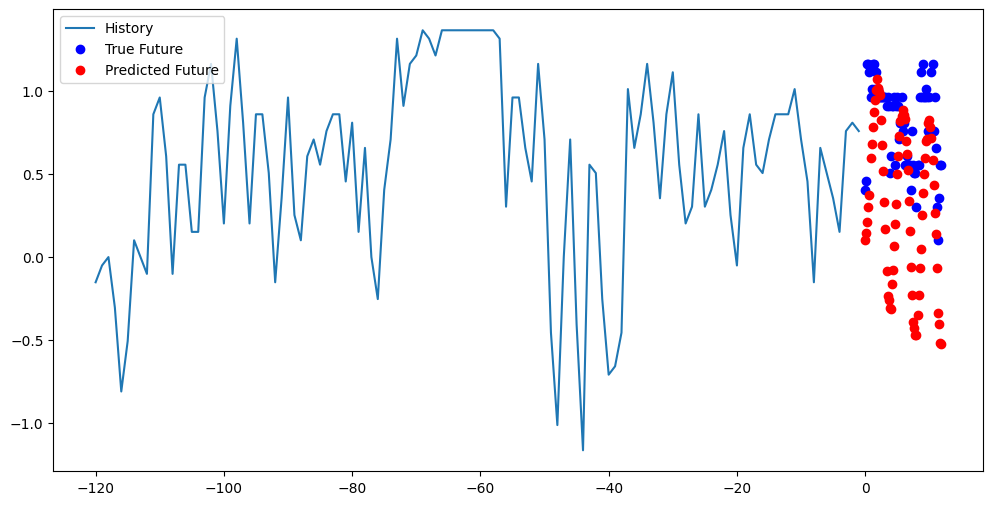

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


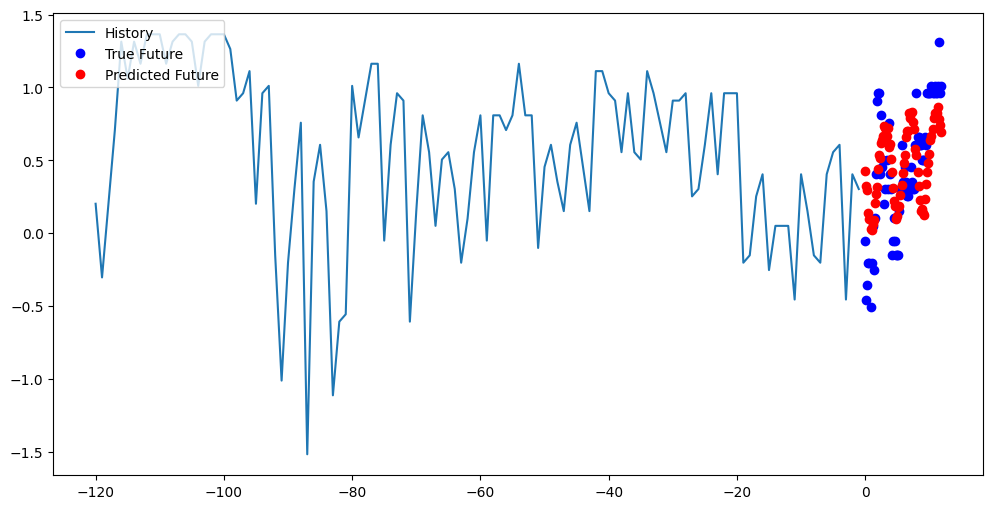

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


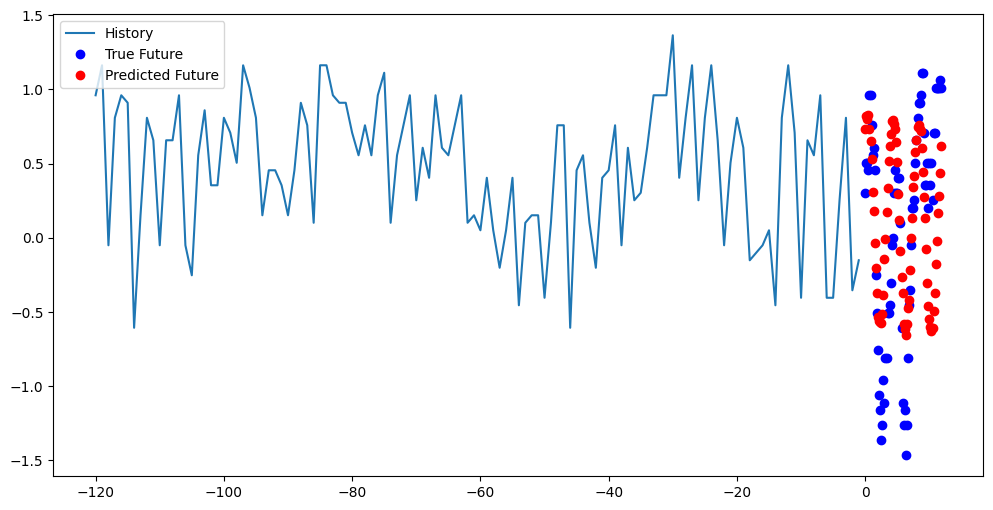

2024-06-18 15:30:56.488334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [40]:
for x, y in val_data_multi.take(3):

  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])